In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [6]:
# データの読み込み
data = pd.read_csv('dataframe.csv')
X = data.iloc[:, :-1].values  # 入力データ (スピン配位)
y = data.iloc[:, -1].values   # 教師データ (温度)

In [11]:
# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# NumPy配列からPyTorchのテンソルに変換
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # (25000,) -> (25000, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)    # (6250,) -> (6250, 1)

In [13]:
# データセットの作成
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [14]:
# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [15]:
# ニューラルネットワークモデルの定義
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x

In [16]:
# モデルの初期化
input_size = 100
hidden_size = 64
output_size = 25
model = NeuralNetwork(input_size, hidden_size, output_size)

In [17]:
# KLダイバージェンス損失関数の定義
class KLDivergenceLoss(nn.Module):
    def __init__(self):
        super(KLDivergenceLoss, self).__init__()

    def forward(self, output, target):
        loss = nn.KLDivLoss(reduction='batchmean')
        return loss(torch.log(output), target)

In [18]:
# 損失関数と最適化アルゴリズムの設定
criterion = KLDivergenceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [19]:
# 学習の実行
num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()  # モデルを学習モードに設定

    for inputs, targets in train_loader:
        optimizer.zero_grad()       # 勾配を初期化
        outputs = model(inputs)     # フォワードパス
        loss = criterion(outputs, targets)
        loss.backward()            # バックプロパゲーション
        optimizer.step()           # パラメータの更新

    model.eval()   # モデルを評価モードに設定
    with torch.no_grad():
        test_loss = 0.0
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs, targets)

    test_loss /= len(test_loader)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {test_loss:.4f}')

Epoch [1/50], Test Loss: 338.4048
Epoch [2/50], Test Loss: 338.4048
Epoch [3/50], Test Loss: 338.4048
Epoch [4/50], Test Loss: 338.4048
Epoch [5/50], Test Loss: 338.4081
Epoch [6/50], Test Loss: 338.4048
Epoch [7/50], Test Loss: 338.4048
Epoch [8/50], Test Loss: 338.4050
Epoch [9/50], Test Loss: 338.4048
Epoch [10/50], Test Loss: 338.4048
Epoch [11/50], Test Loss: 338.4048
Epoch [12/50], Test Loss: 338.4048
Epoch [13/50], Test Loss: 338.4048
Epoch [14/50], Test Loss: 338.4048
Epoch [15/50], Test Loss: 338.4048


KeyboardInterrupt: 

Final Test Loss: 35.5383


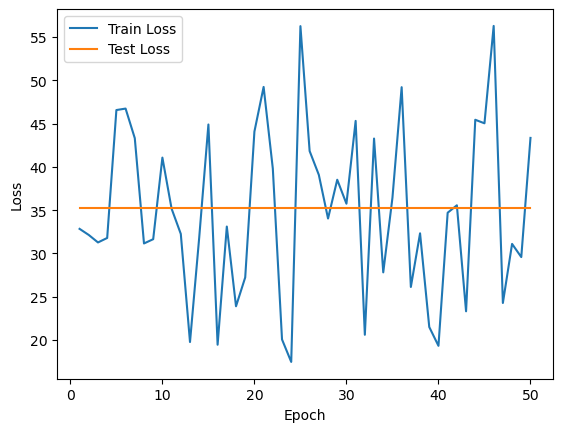

In [17]:
# モデルの評価
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Final Test Loss: {test_loss:.4f}')

# 損失の可視化
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()